<a href="https://colab.research.google.com/github/SapnaNauhriaMicrosoft/skills-code-with-codespaces/blob/main/Q1_DL_Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
#@title Imports (RUN ME!) { display-mode: "form" }

!pip install tensorflow-gpu==2.0.0-beta0 > /dev/null 2>&1

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

print("TensorFlow executing eagerly: {}".format(tf.executing_eagerly()))

TensorFlow executing eagerly: True


#The Data

In [51]:
# Tensorflow has convenient modules for loading a number of standard datasets
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_and_validation_images, train_and_validation_labels), (test_images, test_labels) = fashion_mnist.load_data()

text_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Construct a validation set

In [52]:
# Construct a validation set from the last 10000 images and labels from
# train_and_validation_images and train_and_validation_labels
validation_images = train_and_validation_images[-10000:, :, :]
validation_labels = train_and_validation_labels[-10000:]

# Construct a training set from the first 50000 images and labels.
train_images = train_and_validation_images[:50000, :, :]
train_labels = train_and_validation_labels[:50000]

# Data Visualization

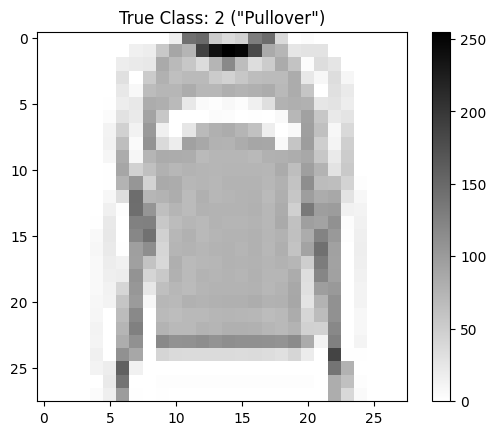

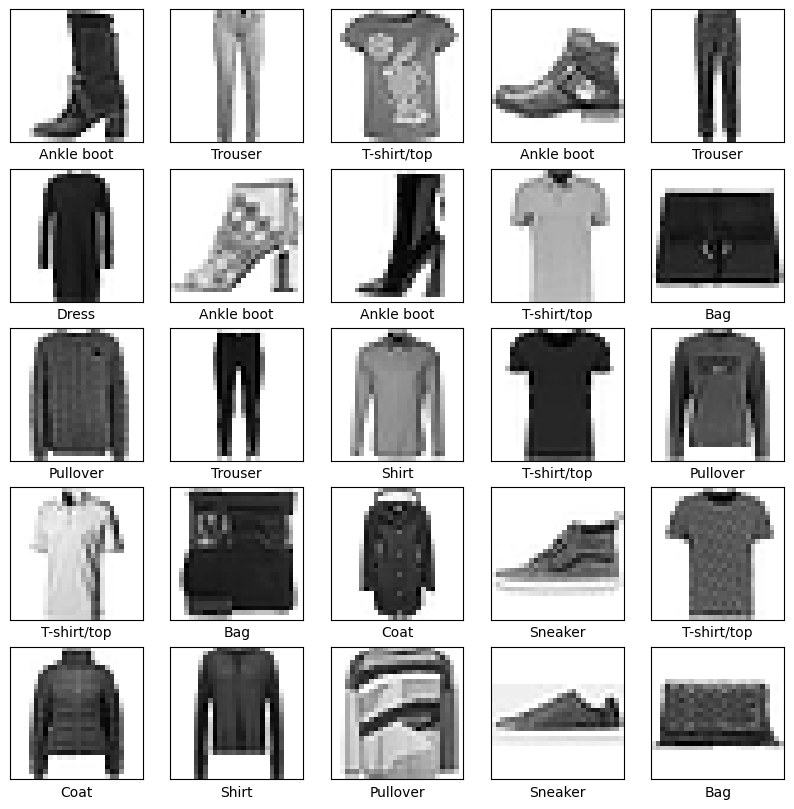

In [53]:
# We use the Matplotlib plotting library to visualise an image selected at random from the training set
plt.figure()
random_index = np.random.randint(0, len(train_images))
plt.imshow(train_images[random_index], cmap='gray_r')
plt.colorbar()
numerical_label = train_labels[random_index]
text_description = text_labels[numerical_label]
plt.title('True Class: {} ("{}")'.format(numerical_label, text_description))

plt.gca().grid(False)

# Another view, showing 25 randomly selected images at a time
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    img_index = np.random.randint(0, 50000)
    plt.imshow(train_images[img_index], cmap="gray_r")
    plt.xlabel(text_labels[train_labels[img_index]])

# Preparing the data with TensorFlow

In [54]:
batch_size = 128



In [55]:
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))

In [56]:
# Divide image values and cast to float so that they end up as a floating point number between 0 and 1
train_ds = train_ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, tf.cast(y, tf.int32)))

In [57]:
# Shuffle the examples.
train_ds = train_ds.shuffle(buffer_size=batch_size * 10)

In [58]:
# Now "chunk" the examples into batches
train_ds = train_ds.batch(batch_size)

# The output of this pipeline will be tuples of tensors containing images and labels.
# The images will be of shape (batch_size, 28, 28) and the labels of shape (batch_size, )

In [59]:
# Don't worry about this for now, we will use the validation set later
val_ds = tf.data.Dataset.from_tensor_slices((validation_images, validation_labels))
val_ds = val_ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, tf.cast(y, tf.int32)))
val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Configure the feed-forward neural network

In [60]:
# RE-RUN THIS CELL if you want to restart training!
model = tf.keras.Sequential([
    # Convert the 28x28 image into a flat vector of 28x28 = 784 values
    tf.keras.layers.Flatten(input_shape=(28, 28), name='flatten_input'),
    # Create a "hidden" layer with 256 neurons and apply the ReLU non-linearity
    tf.keras.layers.Dense(256, activation=tf.nn.relu, name='input_to_hidden1'),
    # Create another hidden layer with 128 neurons
    tf.keras.layers.Dense(128, activation=tf.nn.relu, name='hidden1_to_hidden2'),
    # Create an "output layer" with 10 neurons
    tf.keras.layers.Dense(10, name='hidden_to_logits'),
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [61]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_input (Flatten)         │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ input_to_hidden1 (Dense)        │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden1_to_hidden2 (Dense)      │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_to_logits (Dense)        │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,146 (918.54 KB)

 Trainable params: 235,146 (918.54 KB)

 Non-trainable params: 0 (0.00 B)

# Train the Model
Defining Training Loop

In [62]:
# Choose an optimizer and loss function for training:
# The optimizer is responsible for controlling the learning rate
optimizer = tf.keras.optimizers.Adam()  # Set explicitly for reproducibility
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Select metrics to measure the loss and the accuracy of the model.
# These metrics accumulate the values over epochs and then print the overall result.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

# --- ADD validation metrics ---
val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')

num_epochs = 50  # The number of epochs to run

# Lists to store the loss and accuracy of every epoch
train_losses = []
train_accuracies = []

# --- ADD lists for validation history ---
val_losses = []
val_accuracies = []

# Defined a function to train the model using tf.GradientTape
@tf.function
def train_step(image, label):
  # Initialise a GradientTape to track the operations
  with tf.GradientTape() as tape:
    # Compute the logits (un-normalised scores) of the current batch of examples
    # using the neural network architecture we defined earlier
    logits = model(image)
    loss = loss_object(label, logits)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  # Add current batch loss to our loss metric tracker - note the function call semantics
  train_loss(loss)
  train_accuracy(label, logits)

# Define a function to test the model
# @tf.function
# def val_step(image, label):
  # TODO

# --- ADD a validation step (no gradient tape) ---
@tf.function
def val_step(image, label):
  logits = model(image, training=False)
  v_loss = loss_object(label, logits)
  val_loss(v_loss)
  val_accuracy(label, logits)

for epoch in range(num_epochs):
  # Reset metrics at the start of each epoch
  train_loss.reset_state()
  train_accuracy.reset_state()
  val_loss.reset_state()
  val_accuracy.reset_state()
  # Training loop
  for image, label in train_ds:
    train_step(image, label)

  # Validation loop (end of epoch)
  for image, label in val_ds:
    val_step(image, label)

  template = ('Epoch {:03d}, '
              'Train Loss: {:.3f}, Train Acc: {:.3%} | '
              'Val Loss: {:.3f}, Val Acc: {:.3%}')
  print(template.format(epoch+1,
                        train_loss.result(),
                        train_accuracy.result(),
                        val_loss.result(),
                        val_accuracy.result()))

  train_losses.append(float(train_loss.result()))
  train_accuracies.append(float(train_accuracy.result()))
  val_losses.append(float(val_loss.result()))
  val_accuracies.append(float(val_accuracy.result()))

print('Training finished.')


Epoch 001, Train Loss: 0.535, Train Acc: 81.294% | Val Loss: 0.419, Val Acc: 84.930%
Epoch 002, Train Loss: 0.376, Train Acc: 86.414% | Val Loss: 0.359, Val Acc: 87.210%
Epoch 003, Train Loss: 0.331, Train Acc: 87.896% | Val Loss: 0.360, Val Acc: 87.080%
Epoch 004, Train Loss: 0.310, Train Acc: 88.642% | Val Loss: 0.335, Val Acc: 87.820%
Epoch 005, Train Loss: 0.291, Train Acc: 89.262% | Val Loss: 0.322, Val Acc: 88.210%
Epoch 006, Train Loss: 0.271, Train Acc: 90.002% | Val Loss: 0.327, Val Acc: 88.150%
Epoch 007, Train Loss: 0.258, Train Acc: 90.340% | Val Loss: 0.322, Val Acc: 88.470%
Epoch 008, Train Loss: 0.245, Train Acc: 90.928% | Val Loss: 0.314, Val Acc: 88.580%
Epoch 009, Train Loss: 0.236, Train Acc: 91.192% | Val Loss: 0.348, Val Acc: 87.330%
Epoch 010, Train Loss: 0.224, Train Acc: 91.606% | Val Loss: 0.308, Val Acc: 88.890%
Epoch 011, Train Loss: 0.218, Train Acc: 91.818% | Val Loss: 0.323, Val Acc: 88.550%
Epoch 012, Train Loss: 0.210, Train Acc: 92.116% | Val Loss: 0.33

Plot the training loop

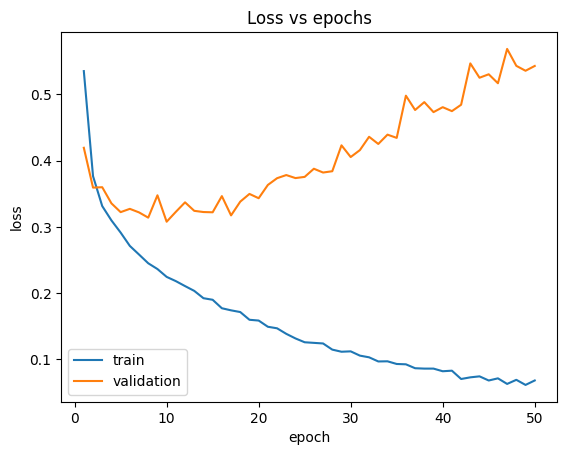

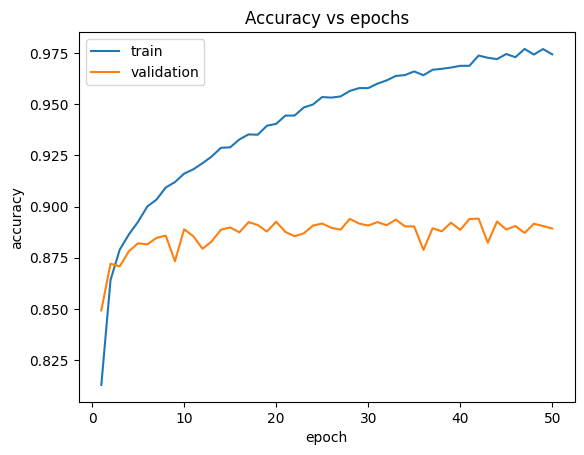

In [63]:
plt.figure()
plt.plot(range(1, num_epochs+1), train_losses, label="train")
plt.plot(range(1, num_epochs+1), val_losses, label="validation")
plt.title('Loss vs epochs')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

plt.figure()
plt.plot(range(1, num_epochs+1), train_accuracies, label="train")
plt.plot(range(1, num_epochs+1), val_accuracies, label="validation")
plt.title('Accuracy vs epochs')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()

Visualise some of the model's prediction on the training set

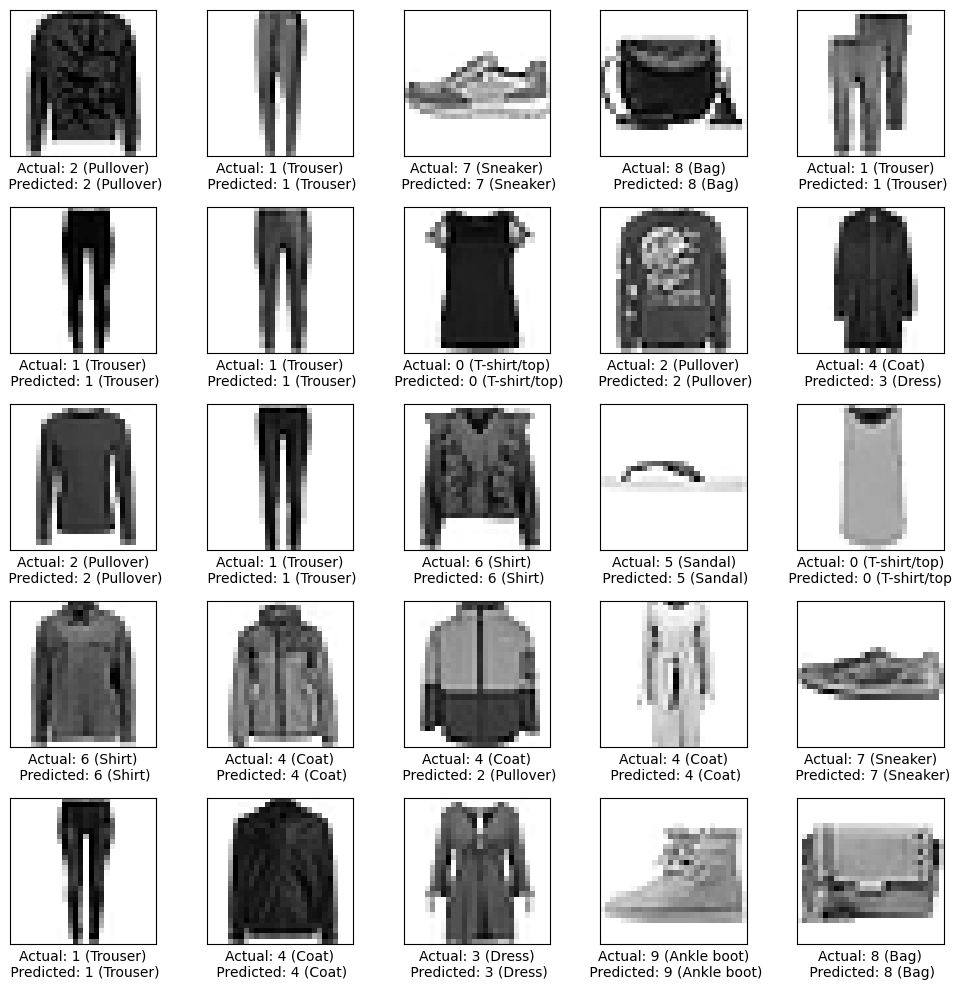

In [64]:
images, labels = next(iter(train_ds))  # Get a batch of images and labels

_logits = model(images, training=False)  # Pass the images to the model function and get its output logits
predicted_labels = tf.argmax(_logits, axis=1, output_type=tf.int32)

img_indexs = np.arange(images.numpy().shape[0])
np.random.shuffle(img_indexs)

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    img_index = img_indexs[i]
    predicted_label = int(predicted_labels[img_index])

    plt.imshow(images[img_index], cmap="gray_r")

    actual_label = int(labels[img_index].numpy())
    plt.xlabel("Actual: {} ({})\n Predicted: {} ({})".format(
        actual_label, text_labels[actual_label], predicted_label, text_labels[predicted_label]
    ))

plt.tight_layout()
plt.show()

# Testing

In [65]:
# We need to apply the same pre-processing to the test set as we did to the training set
# Since we don't need batching or shuffling, we can do this directly instead of
# building a tf.Dataset pipeline

tf_test_images = tf.convert_to_tensor(test_images, dtype=tf.float32) / 255.0
tf_test_labels = tf.convert_to_tensor(test_labels, dtype=tf.int32)

In [66]:
test_logits = model(tf_test_images, training=False)

# Compute the average cross-entropy loss of the classification over the entire test set
test_loss = tf.keras.metrics.Mean(name='test_loss')
t_loss = loss_object(tf_test_labels, test_logits)
test_loss(t_loss)

# Compare predicted labels to actual labels
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')
test_accuracy(tf_test_labels, test_logits)

print('Completed testing on', tf_test_images.shape[0], 'examples...')
print('Loss: {:.3f}, Accuracy: {:.3%}'.format(test_loss.result(), test_accuracy.result()))

Completed testing on 10000 examples...
Loss: 0.611, Accuracy: 88.860%


Visulaizing test data

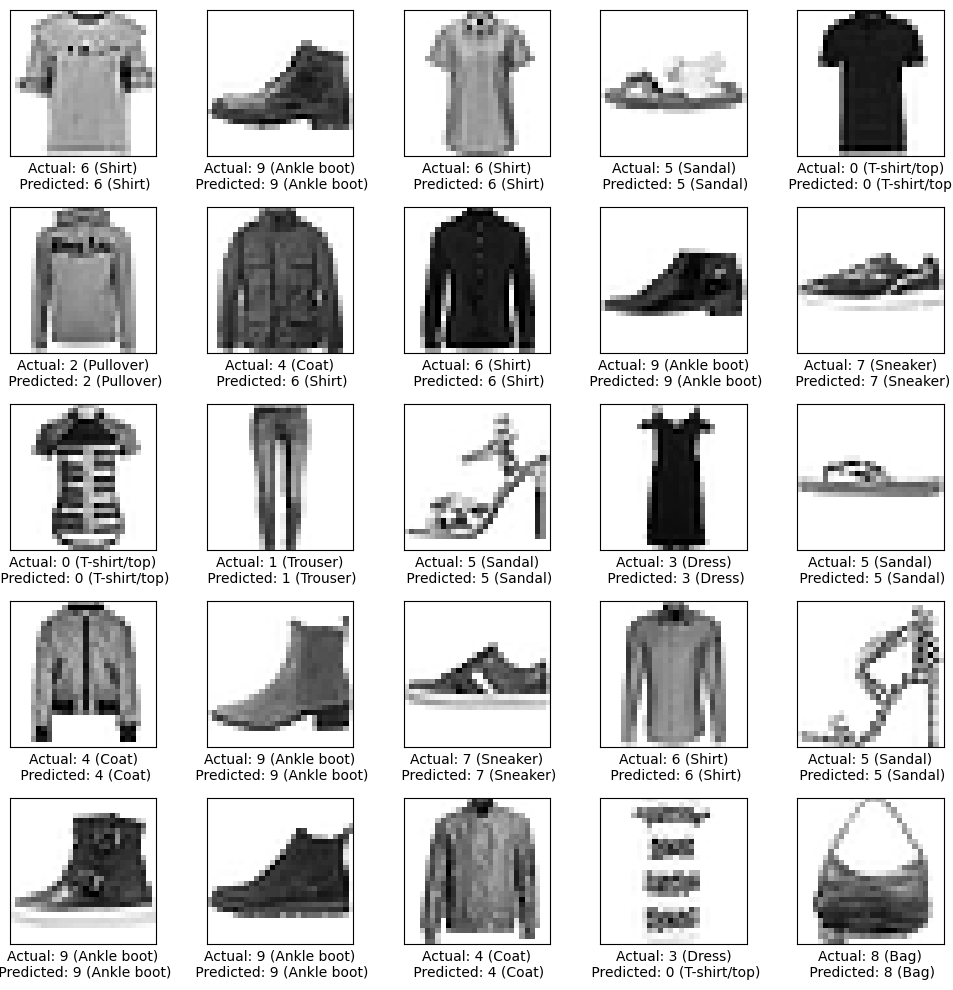

In [67]:
test_predictions = tf.argmax(test_logits, axis=1, output_type=tf.int32)

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    img_index = np.random.randint(0, 10000)
    plt.imshow(test_images[img_index], cmap="gray_r")

    actual_label = int(test_labels[img_index])
    predicted_label = int(test_predictions[img_index])

    plt.xlabel("Actual: {} ({})\n Predicted: {} ({})".format(
        actual_label, text_labels[actual_label], predicted_label, text_labels[predicted_label]
    ))

plt.tight_layout()
plt.show()